In [7]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal
from google.colab import files

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
cd /content/drive/MyDrive/CIS5810/Project_6_Poisson_Image_Blending

/content/drive/MyDrive/CIS5810/Project_6_Poisson_Image_Blending


In [10]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ 
    Creates indexes of replacement area in the target image, each pixel in the 
    replacement area gets index starting from 1, other pixels outside the 
    replacement area get 0.

    Args:
    - mask: SrcH * SrcW, logical mask of source image
    - targetH, targetW: int, height and width of target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Return:
    - indexes: targetH * targetW, indexes of replacement area in target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful

    mask_H, mask_W = mask.shape
    mask_X, mask_y = np.meshgrid(np.arange(mask_W), np.arange(mask_H))

    target_X = mask_X[mask > 0]
    target_y = mask_y[mask > 0]

    indexes = np.zeros([targetH, targetW])

    target_X = target_X + offsetX
    target_y = target_y + offsetY

    indexes[target_y, target_X] = np.arange(1, target_X.shape[0] + 1)

    return indexes

In [11]:
def getCoefficientMatrix(indexes):
    """
    Constructs the coefficient matrix (A in Ax=b)
    
    Args: 
    - indexes: targetH * targetW, indexes of replacement area in target image
    
    Return:
    - A: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
    """
    # IMPLEMENT HERE
    # Since the coefficient matrix A is by nature sparse. Consider using scipy.sparse.csr_matrix to represent A to save space

    indi = int(np.max(indexes))
    idx = np.arange(indi)
    data = 4 * np.ones([indi])
    A = scipy.sparse.csr_matrix((data, (idx, idx)), shape = (indi,indi))

    indexes_x, indexes_y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))
    
    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]
    
    y_neighbor = np.arange(x.shape[0])
    
    #Left Neighbours
    left_neighbor = indexes[y, x-1]
    left_y_neighbor = y_neighbor[left_neighbor > 0]
    left_x_neighbor = (left_neighbor[left_y_neighbor] - 1).astype(int)

    #Right Neighbours
    right_neighbor = indexes[y, x+1]
    right_y_neighbor = y_neighbor[right_neighbor > 0]
    right_x_neighbor = (right_neighbor[right_y_neighbor] - 1).astype(int)

    #Up Neighbours
    up_neighbor = indexes[y-1, x]
    up_y_neighbor = y_neighbor[up_neighbor > 0]
    up_x_neighbor = (up_neighbor[up_y_neighbor] - 1).astype(int)

    #Down Neighbours
    down_neighbor = indexes[y+1, x]
    down_y_neighbor = y_neighbor[down_neighbor > 0]
    down_x_neighbor = (down_neighbor[down_y_neighbor] - 1).astype(int)

    A[left_y_neighbor, left_x_neighbor] = -1
    A[up_y_neighbor, up_x_neighbor] = -1
    A[right_y_neighbor, right_x_neighbor] = -1
    A[down_y_neighbor, down_x_neighbor] = -1

    return A

In [12]:
def getSolutionVect(indexes, source, target, offsetX, offsetY):
    """
    Constructs the target solution vector (b in Ax=b) 
    
    Args:
    - indexes:  targetH * targetW, indexes of replacement area in target image
    - source, target: source and target image
    - offsetX, offsetY: int, offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE

    indexes_x, indexes_y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))

    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    # 1. get Laplacian part of b from source image
    lap = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    s_lap = scipy.signal.convolve2d(source, lap, 'same')

    sec_lap = s_lap[y - offsetY, x - offsetX]
    
    # 2. get pixel part of b from target image

    y_b = np.arange(x.shape[0])

    #Left Neighbours
    left_neighbor = indexes[y, x - 1]
    lx = x-1
    left_x_zero, left_y_zero = lx[left_neighbor == 0], y[left_neighbor == 0]

    left_val = target[left_y_zero, left_x_zero]

    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    #Right Neighbours
    right_neighbor = indexes[y, x + 1]
    rx = x+1
    right_x_zero , right_y_zero = rx[right_neighbor == 0] , y[right_neighbor == 0]

    right_val = target[right_y_zero, right_x_zero]

    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    #Up Neighbours
    up_neighbor = indexes[y - 1, x]
    uy = y-1
    up_x_zero , up_y_zero = x[up_neighbor == 0] , uy[up_neighbor == 0]

    up_val = target[up_y_zero, up_x_zero]

    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    #Down Neighbours
    down_neighbor = indexes[y + 1, x]
    dy = y+1
    down_x_zero , down_y_zero = x[down_neighbor == 0] , dy[down_neighbor == 0]

    down_val = target[down_y_zero, down_x_zero]

    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    # 3. add two parts together to get b

    b = scipy.sparse.csr_matrix(sec_lap + left_b + right_b + up_b + down_b)


    return b

In [13]:
def solveEqu(A, b):
    """
    Solve the equation Ax = b to get replacement pixels x in the replacement area
    Note: A is a sparse matrix, so we need to use corresponding function to solve it

    Args:
    - A: Laplacian coefficient matrix
    - b: target solution vector

    Returns:
    - x: solution of Ax = b
    """
    # IMPLEMENT HERE
    # you may find scipy.sparse.linalg.spsolve useful to solve equation

    x = scipy.sparse.linalg.spsolve(A, b)


    return x

In [14]:
def reconstructImg(indexes, red, green, blue, target):
    """
    Reconstruct the target image with new red, green, blue channel values in the 
    indexes area

    Args:
    - indexes: targetH * targetW, indexes of replacement area in target image
    - red, green, blue: 1 x N, three chanels for replacement pixel values
    - target: target image
    
    Returns:
    - resultImg: reconstructed target image with poisson editing
    """
    # IMPLEMENT HERE
    # 1. get nonzero component in indexes
    indexes_x, indexes_y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))

    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    # 2. stack three channels together with numpy dstack
    channels = np.dstack([red, green, blue])

    # 3. copy new pixels in the indexes area to the target image
    target[y,x,:] = channels
    resultImg = target


    return resultImg

### Seamless Cloning Poisson Editing

In [15]:
"""
Function (do not modify)
"""
def seamlessCloningPoisson(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image
    
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


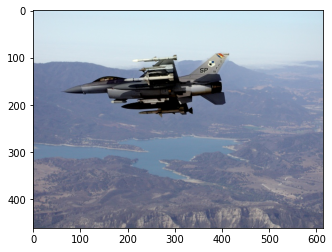

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
"""
Script (do not modify)
"""
src_path = 'Images/source_3.jpg'
src = np.array(Image.open(src_path).convert('RGB'), 'f') / 255
target_path  ='Images/target_3.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
offsetX = 40
offsetY = 20
mask_path = 'Images/mask_3.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = seamlessCloningPoisson(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
cloned = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
cloned.save('cloned.png')
files.download('cloned.png')

### Mixing gradient Poisson Editing

In [17]:
def getSolutionVectMixing(indexes, source, target, offsetX, offsetY):
    """
    Constructs the target solution vector(b in Ax=b) 
    
    Args:
    - indexes:  targetH * targetW, indexes of replacement area
    - source, target: source and target image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    indexes_x, indexes_y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))

    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    # 1. get Laplacian part of b from source image
    laplacian = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    source_laplacian = scipy.signal.convolve2d(source, laplacian, 'same')
    target_laplacian = scipy.signal.convolve2d(target, laplacian, 'same')

    source_y = y - offsetY
    source_x = x - offsetX

    tmp_src = source_laplacian[source_y, source_x]
    tmp_target = target_laplacian[y,x]

    lap_b = np.where(np.abs(tmp_src) >= np.abs(tmp_target), tmp_src, tmp_target)
    
    # 2. get pixel part of b from target image

    y_b = np.arange(x.shape[0])

    #Left Neighbours
    lx = x-1
    left_neighbor = indexes[y, lx]

    left_y_zero = y[left_neighbor == 0]
    left_x_zero = lx[left_neighbor == 0]

    left_val = target[left_y_zero, left_x_zero]

    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    #Right Neighbours
    rx = x + 1
    right_neighbor = indexes[y, rx]

    right_y_zero = y[right_neighbor == 0]
    right_x_zero = rx[right_neighbor == 0]

    right_val = target[right_y_zero, right_x_zero]

    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    #Up Neighbours
    uy = y - 1
    up_neighbor = indexes[uy, x]

    up_y_zero = uy[up_neighbor == 0]
    up_x_zero = x[up_neighbor == 0]

    up_val = target[up_y_zero, up_x_zero]

    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    #Down Neighbours
    dy = y + 1
    down_neighbor = indexes[dy, x]

    down_y_zero = dy[down_neighbor == 0]
    down_x_zero = x[down_neighbor == 0]

    down_val = target[down_y_zero, down_x_zero]

    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    # 3. add two parts together to get b

    b = scipy.sparse.csr_matrix(lap_b + left_b + right_b + up_b + down_b)


    return b

In [18]:
"""
Function (do not modify)
"""
def PoissonMixing(sourceImg, targetImg, mask, offsetX, offsetY):
    """
    Wrapper function to put all steps together
    
    Args:
    - sourceImg, targetImg: source and target image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image
    
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1], offsetX,
                         offsetY)
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectMixing(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        offsetX, offsetY).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

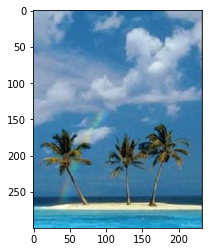

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
"""
Script (do not modify)
"""
src_path = 'Images/source_2.jpg'
src = Image.open(src_path).convert('RGB')

src = np.array(src, 'f') / 255
target_path  ='Images/target_2.jpg'
target = Image.open(target_path).convert('RGB')
target = np.array(target, 'f') / 255
offsetX = 10
offsetY = 130
mask_path = 'Images/mask_2.bmp'
mask = Image.open(mask_path)
mask =np.array(mask) > 0
result = PoissonMixing(src, target, mask, offsetX, offsetY)
plt.imshow(result)
plt.show()
mixed = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
mixed.save('mixed.png')
files.download('mixed.png')

### Texture Flattening Poisson Editing

In [20]:
def getSolutionVectTexture(indexes, target, mask, edges):
    """
    Constructs the target solution vector(b in Ax=b) 
    
    Args:
    - indexes:  targetH * targetW, indexes of replacement area
    - source, target: source and target image
    - offsetX, offsetY: offset of source image origin in the target image

    Returns:
    - solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    indexes_x, indexes_y = np.meshgrid(np.arange(indexes.shape[1]), np.arange(indexes.shape[0]))

    x = indexes_x[indexes > 0]
    y = indexes_y[indexes > 0]

    # 1. get Laplacian part of b from source image
    
    b_left_edge = np.where(np.logical_or(edges[y,x], edges[y,x-1]) == True, target[y, x] - target[y, x - 1], 0)
    b_right_edge = np.where(np.logical_or(edges[y,x], edges[y,x+1]) == True, target[y, x] - target[y, x+1], 0)
    b_up_edge = np.where(np.logical_or(edges[y,x], edges[y-1,x]) == True, target[y, x] - target[y-1, x], 0)
    b_down_edge = np.where(np.logical_or(edges[y,x], edges[y+1,x]) == True, target[y, x] - target[y+1, x], 0)

    lap_b = b_up_edge + b_left_edge + b_down_edge + b_right_edge
    
    # 2. get pixel part of b from target image

    y_b = np.arange(x.shape[0])

    #Left Neighbours
    lx = x - 1
    left_neighbor = indexes[y, lx]

    left_y_zero = y[left_neighbor == 0]
    left_x_zero = lx[left_neighbor == 0]

    left_val = target[left_y_zero, left_x_zero]

    left_b = np.zeros(x.shape[0])
    left_b[y_b[left_neighbor == 0]] = left_val

    #Right Neighbours
    rx = x + 1
    right_neighbor = indexes[y, rx]

    right_y_zero = y[right_neighbor == 0]
    right_x_zero = rx[right_neighbor == 0]

    right_val = target[right_y_zero, right_x_zero]

    right_b = np.zeros(x.shape[0])
    right_b[y_b[right_neighbor == 0]] = right_val

    #Up Neighbours
    uy = y - 1
    up_neighbor = indexes[y - 1, x]

    up_y_zero = uy[up_neighbor == 0]
    up_x_zero = x[up_neighbor == 0]

    up_val = target[up_y_zero, up_x_zero]

    up_b = np.zeros(x.shape[0])
    up_b[y_b[up_neighbor == 0]] = up_val

    #Down Neighbours
    dy = y + 1
    down_neighbor = indexes[y+1, x]

    down_y_zero = dy[down_neighbor == 0]
    down_x_zero = x[down_neighbor == 0]

    down_val = target[down_y_zero, down_x_zero]

    down_b = np.zeros(x.shape[0])
    down_b[y_b[down_neighbor == 0]] = down_val

    # 3. add two parts together to get b

    b=lap_b + left_b + right_b + up_b + down_b

    # b = scipy.sparse.csr_matrix(lap_b + left_b + right_b + up_b + down_b)

    return b

In [21]:
"""
Function (do not modify)
"""
def PoissonTextureFlattening(targetImg, mask, edges):
    """
    Wrapper function to put all steps together
    
    Args:
    - targetImg: target image
    - mask: logical mask of source image
    - offsetX, offsetY: offset of source image origin in the target image
    
    Returns:
    - ResultImg: result image
    """
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, targetImg[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

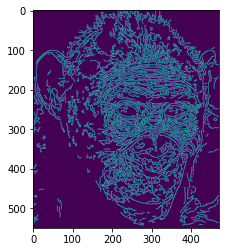

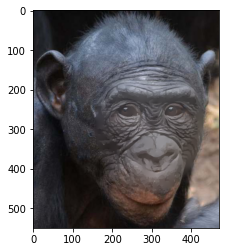

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
"""
Script (do not modify)
"""
target_path  ='Images/bonobo.jpg'
target = np.array(Image.open(target_path).convert('RGB'), 'f') / 255
from skimage.color import rgb2gray
from skimage import feature
edges = feature.canny(rgb2gray(target))
plt.imshow(edges)
plt.show()
mask_path = 'Images/mask_bonobo.bmp'
mask = np.array(Image.open(mask_path)) > 0
result = PoissonTextureFlattening(target, mask, edges)
plt.imshow(result)
plt.show()
flatten = Image.fromarray((np.clip(result, 0, 1) * 255).astype(np.uint8))
flatten.save('flatten.png')
files.download('flatten.png')